### Recurrent Neural Network 

#### EDA Conclusions

In addition to our newly-acquired EDA insights from our previous operations (see EDA notebook) we can be fairly confident to have conclusions such as how our heavily skewed raw data has an overall decreasing trend in total sales, how the daily historical sales have a yearly seasonal cyclical pattern, and how our sales training data has stationarity and we can begin our forecasting endeavors since most statistical modeling and machine learning methods assume or require time series data to be stationary.

##### Training, Prediction, and Submission 

After researching various resources including Kaggle kernels, various data science blogs, and Github repositories including luliu31415926's who ranked 6th on Kaggle's public leaderboard in the same 1C competition and also from a Github of entron's, the winner of a similar competition to 1C Company called Rossman Sales, we will now attempt to solve our prediction problem via an embedding neural network since multiple research findings indicate that it is the best single model including evidence from studying the winning solutions of multiple similar competitions. 

Combining our EDA insights and research findings, we decided to employ a recurrent neural network model call long short-term memory (LSTM). Each LSTM network unit will be responsible for ‘remembering’ values over arbitrary time intervals to help us with our forecast. We hope that the model is robust enough to tackle situations for our nuanced datasets that have changes for shops and items from month to month. We will then calculate the root mean squared error to evaluate our model. 

In [59]:
# Import necessary packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from math import ceil
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
%matplotlib inline

train = pd.read_csv('/Users/kaizen/Data Science/Capstone 2/Competition Data/sales_train.csv')
test = pd.read_csv('/Users/kaizen/Data Science/Capstone 2/Competition Data/test.csv')
submission = pd.read_csv('/Users/kaizen/Data Science/Capstone 2/Competition Data/sample_submission.csv')
items = pd.read_csv('/Users/kaizen/Data Science/Capstone 2/Competition Data/items.csv')
item_cats = pd.read_csv('/Users/kaizen/Data Science/Capstone 2/Competition Data/item_categories.csv')
shops = pd.read_csv('/Users/kaizen/Data Science/Capstone 2/Competition Data/shops.csv')


In [60]:
# Ensure all data in shop and items in the test set is also in the training set
test_shops = test.shop_id.unique()
train = train[train.shop_id.isin(test_shops)]
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]

Since there are close to 3 million items in our sales training data and the sale data from early 2013 is unlikely to have high predictive power for Novembmer 2015 sales prediction, it will be more efficient if we examine the patterns of how each shop and item category vary over time while narrowing our data to the months leading up to November (July-October) in 2013 and 2014. 

In [61]:
# Create variables to narrow down data for LSTM modeling 
MAX_BLOCK_NUM = train.date_block_num.max()
MAX_ITEM = len(test_items)
MAX_CAT = len(item_cats)
MAX_YEAR = 3
MAX_MONTH = 4 # 7 8 9 10
MAX_SHOP = len(test_shops)

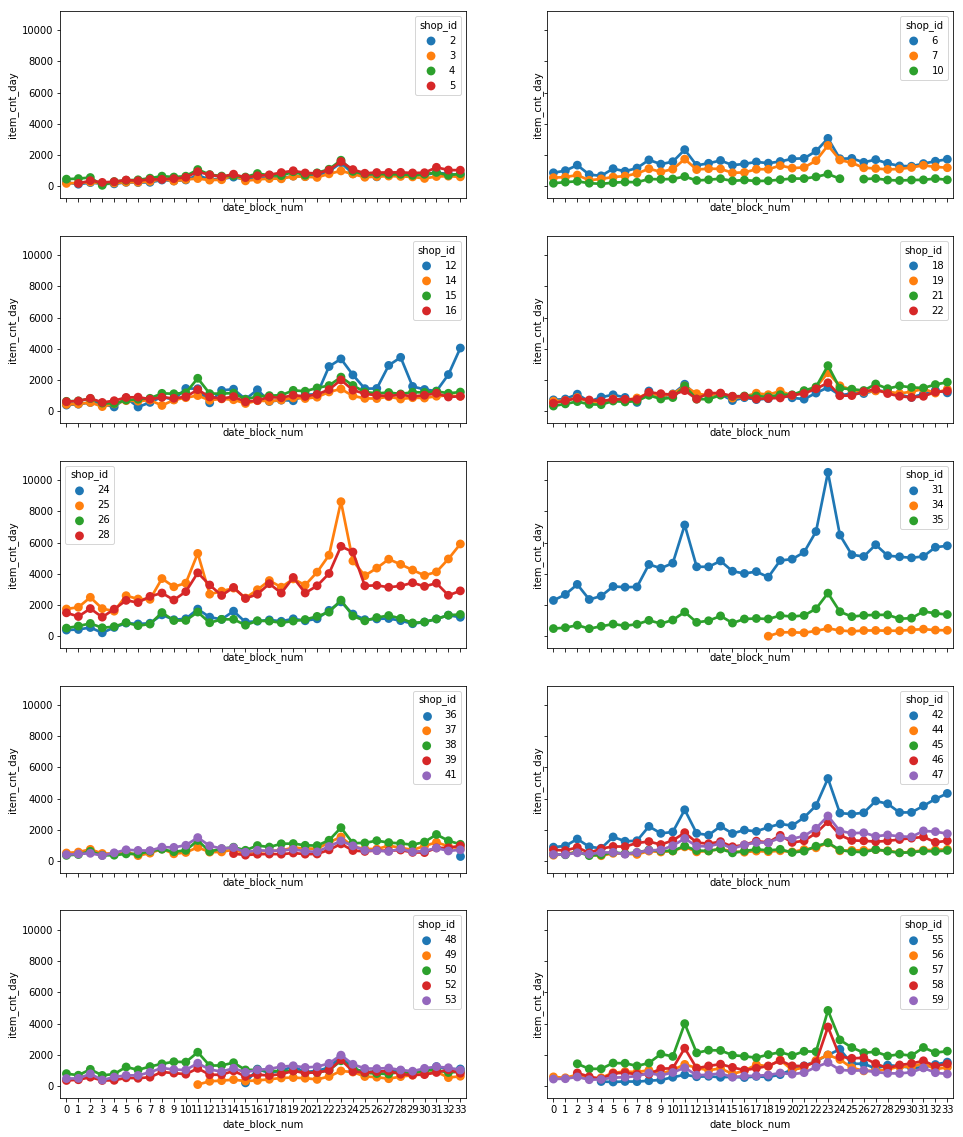

In [62]:
# Data explorationv visualizations for all shops from EDA notebook
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

We note again the increases towards the end of each year around November indicating higher sales during the beginning of each holiday season. Thus, we will add the categories of month and year so our neural network will recognize this pattern. 

In [63]:
# Reformat our sales dataframe 
train = train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()

In [64]:
# Add categories 
train['month'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%m'))
train['year'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y'))

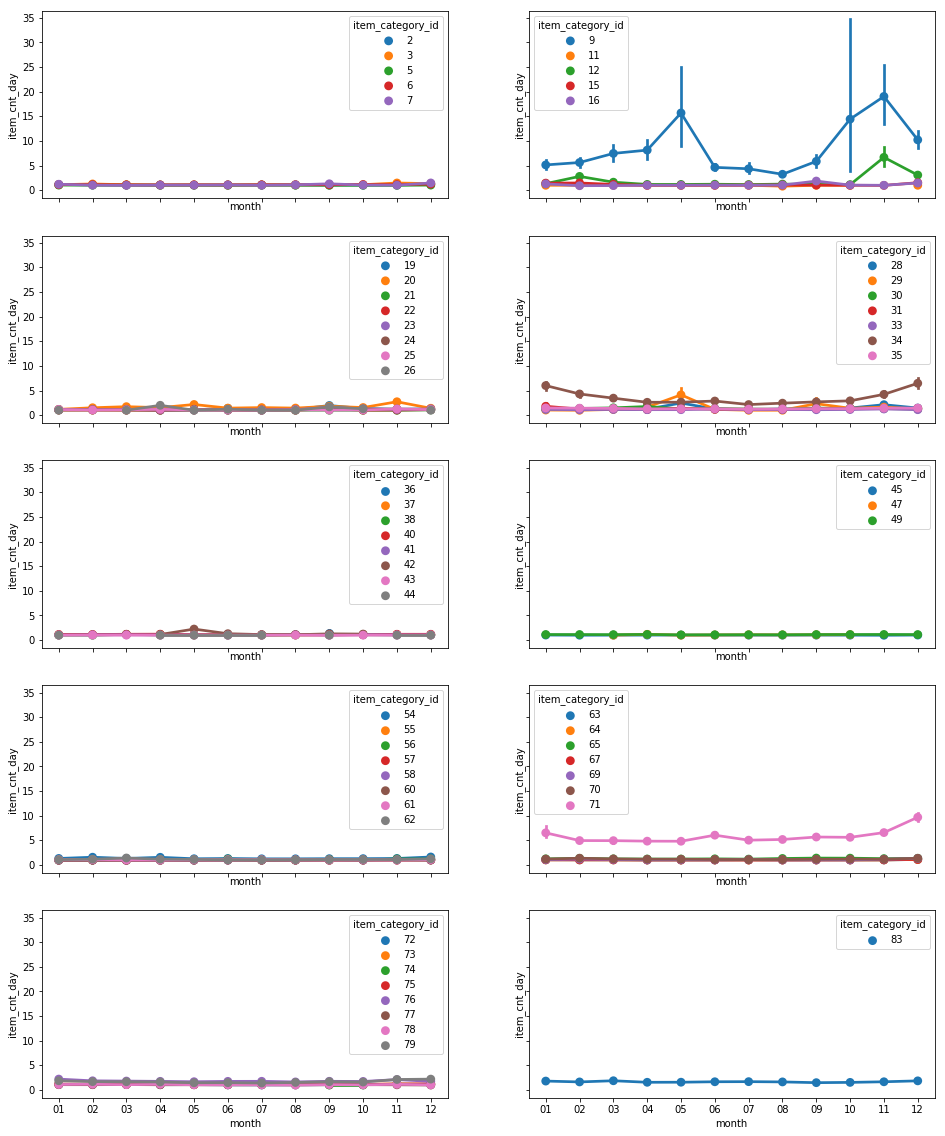

In [65]:
# Display again plots of historical monthly sales for each item category 
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

We recognize from the display above that only a few categories such as 8, 9 and 71 do better overall and vary significantly on a monthly basis in all 34 months while most other categories have constant monthly sales. Below, we will plot the trends of sales for all 34 months for each item category. 

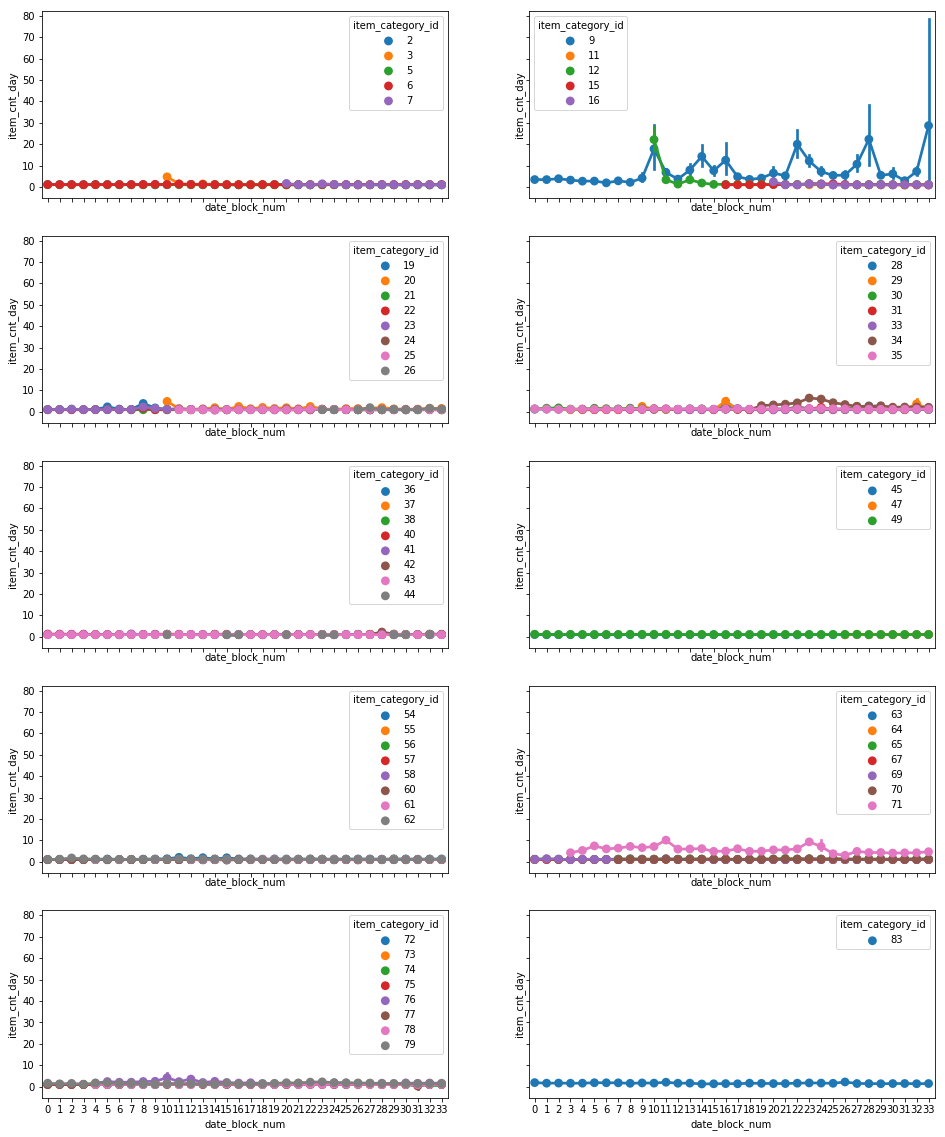

In [66]:
# Display again plots of historical sales for each item category for all 34 months
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

We see above again that generally, most stores actually have a fairly constant trend with a few exceptions with a similar seasonal trend as our previous total sales plot for the entire company. Thus, because of the large numbers of items, we will skip the tedious task of looking at the trends for each item and just focus on the monthly and yearly trends for each of the 60 shops and 84 item categories. 

#### Recurrent Neural Network 

We now begin to build our recurrent neural network units for training and prediction tasks. Our long short-term memory (LSTM) networks are composed of units that each contain a cell, an input gate, an output gate, and forget gate. Each cell is responsible for remembering values over arbitrary time intervals, which should help us with our time-series data that contain changes in shop and item categories from month to month. 

In [67]:
# Reformat our data for training
train = train.drop('date', axis=1)
train = train.drop('item_category_id', axis=1)
train = train.groupby(['shop_id', 'item_id', 'date_block_num', 'month', 'year']).sum()
train = train.sort_index()

In [68]:
# Normalize training data to speed up learning
scaler = StandardScaler()
cnt_scaler = StandardScaler()

scaler.fit(train.item_price.as_matrix().reshape(-1, 1))
cnt_scaler.fit(train.item_cnt_day.as_matrix().reshape(-1, 1))

train.item_price = scaler.transform(train.item_price.as_matrix().reshape(-1, 1))
train.item_cnt_day = cnt_scaler.transform(train.item_cnt_day.as_matrix().reshape(-1, 1))

Since we are using a narrower sequence for our machine learning, we will have to fill in the resulting empty values with the closest past record due to the price of each item varying slightly by store location and month. Our data is now significantly smaller from 3 million rows to 600,159 leading to a reasonable 30% test set fo 214,200.  

In [69]:
train.reset_index().groupby(['item_id', 'date_block_num', 'shop_id']).mean()

item_price  item_cnt_day
item_id date_block_num shop_id                          
30      1              3         -0.072265      0.115543
                       4          0.041532      0.381274
                       5         -0.072265      0.204120
                       6          0.314142      2.241392
                       7          0.149626      0.647005
                       10        -0.186490      0.115543
                       12        -0.242961     -0.150189
                       14         0.149626      0.469851
                       15         0.208426      1.178467
                       16         0.097005      1.178467
                       18        -0.072265      0.292697
                       19         0.152478      1.089890
                       21         0.098431      0.912736
                       22         0.041532      0.558428
                       24         0.326026      1.089890
                       25         0.439823      4.012933
                       26         0.316329      1.709929
                       28         0.661704      4.987280
                       31         0.665965      9.681864
                       35         0.142971      1.178467
                       37         0.212228      1.089890
                       38         0.098431      0.469851
                       41        -0.186062     -0.061612
                       42         0.548283      3.835779
                       44         0.269127      1.355621
                       45        -0.015366      0.292697
                       46         0.382925      1.621352
                       47         0.089854      0.647005
                       50         0.494821      2.329969
                       52        -0.129164      0.204120
...                                    ...           ...
22167   30             52        -0.214583     -0.061612
        31             2         -0.257221     -0.150189
                       12        -0.129306      0.115543
                       22         0.041247      0.912736
                       25        -0.214583     -0.061612
                       26        -0.257221     -0.150189
                       31        -0.257221     -0.150189
                       35        -0.257221     -0.150189
                       39        -0.257221     -0.150189
                       42        -0.171945      0.026965
                       52        -0.214583     -0.061612
        32             12        -0.044030      0.292697
                       21        -0.214583     -0.061612
                       22        -0.129306      0.115543
                       24        -0.257221     -0.150189
                       25        -0.129306      0.115543
                       42        -0.171945      0.115543
        33             6         -0.257221     -0.150189
                       10        -0.277756     -0.150189
                       12        -0.001391      0.381274
                       18        -0.257221     -0.150189
                       21        -0.257221     -0.150189
                       22         0.162767      1.001313
                       25        -0.214583      0.026965
                       26        -0.257221     -0.150189
                       28        -0.257221     -0.150189
                       37        -0.257221     -0.150189
                       42        -0.171945      0.115543
                       47        -0.257221     -0.150189
                       50        -0.257221     -0.150189

[600159 rows x 2 columns]

In [70]:
# Regroup our dataframe 
price = train.reset_index().set_index(['item_id', 'shop_id', 'date_block_num'])
price = price.sort_index()

In [71]:
price.head(2)

month  year  item_price  item_cnt_day
item_id shop_id date_block_num                                      
30      2       2                 03  2013   -0.248665     -0.150189
                5                 06  2013   -0.242961     -0.150189

In [72]:
# Create functions to help us fill in our dataframe 
def convert(date_block):
    date = datetime(2013, 1, 1)
    date += relativedelta(months = date_block)
    return (date.month, date.year)

def closest_date_block(current_day, item_id, shop_id):
    """Find the block_date which is closest to the current_day, given item_id and shop_id. Returns index integer"""
    if (item_id, shop_id) in price.index:
        search_lst = np.array(price.loc[(item_id, shop_id)].index)        
        return search_lst[np.abs(current_day - search_lst).argmin()]
    return -1
                
def closest_price(current_day, item_id, shop_id):
    closest_date = closest_date_block(current_day, item_id, shop_id)
    if closest_date != -1:
        return price.loc[( item_id, shop_id, closest_date )]['item_price']
    return np.nan

def closest_price_lambda(x):
    return closest_price(34, x.item_id, x.shop_id)

In [73]:
assert closest_date_block(18, 30, 5) == 18

In [74]:
# Determine which month to start our machine learning model
print(convert(6))
print(convert(18))
print(convert(30))

(7, 2013)
(7, 2014)
(7, 2015)


Next we will go through our entire refined dataframe to find out what block we should train on. Please note the long computation time is about ~20-25 minutes

In [76]:
%%time 
maxlen = 4 # 4 months
step = 1
# 0: train, 1: val, 2:test
sentences = [[],[],[]]
next_chars = [[], []]
BLOCKS = [6, 18, 30]


for s in test_shops:
    shop_items = list(train.loc[s].index.get_level_values(0).unique())
    for it in shop_items:        
        for i_index, i in enumerate(BLOCKS):
            sentence = []
            closest_pc = closest_price(i, it, s)            
            for j in range(maxlen+1):
                if j < maxlen:
                    if (s, it, i+j) in train.index:
                        r = train.loc[(s, it, i + j)].to_dict(orient='list')                    
                        closest_pc = r['item_price'][0]
                        item_cnt_day = r['item_cnt_day'][0]
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': item_cnt_day, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    else:
                        month, year = convert(i+j)                    
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': 0, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    sentence.append(row)
                elif i_index < 2:   # not in test set
                    next_chars[i_index].append(row)
            sentences[i_index].append(sentence)

CPU times: user 17min 46s, sys: 11.2 s, total: 17min 57s
Wall time: 17min 59s


In [77]:
# Create training arrays 
x_train_o = np.array(sentences[0])
x_val_o = np.array(sentences[1])
x_test_o = np.array(sentences[2])
y_train = np.array([x['item_cnt_day'] for x in next_chars[0]])
y_val = np.array([x['item_cnt_day'] for x in next_chars[1]])

In [78]:
length = MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1 + 1

In [79]:
# We now transform our categorical features using one-hot encoding 
from sklearn import preprocessing
shop_le = preprocessing.LabelEncoder()
shop_le.fit(test_shops)
shop_dm = dict(zip(test_shops, shop_le.transform(test_shops)))

item_le = preprocessing.LabelEncoder()
item_le.fit(test_items)
item_dm = dict(zip(test_items, item_le.transform(test_items)))

month_le = preprocessing.LabelEncoder()
month_le.fit(range(7,11))
month_dm = dict(zip(range(7,11), month_le.transform(range(7,11))))


In [80]:
# Define vectorization function for x_train, x_val, x_test
def vectorize(inp):
    print('Vectorization...')   
    x = np.zeros((len(inp), maxlen, length), dtype=np.float32)
    for i, sentence in enumerate(inp):
        for t, char in enumerate(sentence):            
            x[i][t][ shop_dm[char['shop_id']] ] = 1        
            x[i][t][ MAX_SHOP + item_dm[char['item_id']] ] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + month_dm[char['month']] ] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 ] = char['item_price']
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1] = char['item_cnt_day']    
    return x

In [81]:
x_train = vectorize(x_train_o)
x_val = vectorize(x_val_o)
x_test = vectorize(x_test_o)

Vectorization...
Vectorization...
Vectorization...


In [82]:
# We now fit our data to a single LSTM model 
print('Build model...')
model = Sequential()
model.add(LSTM(32, input_shape=(maxlen, length)))
model.add(Dense(1, activation='relu'))

optimizer = RMSprop(lr=0.005)
model.compile(loss='mean_squared_error', optimizer=optimizer)

model.fit(x_train, y_train, batch_size=128, epochs=13)

Build model...
Epoch 1/13
111404/111404 [==============================] - 244s 2ms/step - loss: 0.0969
Epoch 2/13
111404/111404 [==============================] - 218s 2ms/step - loss: 0.0776
Epoch 3/13
111404/111404 [==============================] - 216s 2ms/step - loss: 0.0658
Epoch 4/13
111404/111404 [==============================] - 208s 2ms/step - loss: 0.0585
Epoch 5/13
111404/111404 [==============================] - 210s 2ms/step - loss: 0.0572
Epoch 6/13
111404/111404 [==============================] - 195s 2ms/step - loss: 0.0589
Epoch 7/13
111404/111404 [==============================] - 224s 2ms/step - loss: 0.0481
Epoch 8/13
111404/111404 [==============================] - 215s 2ms/step - loss: 0.0564
Epoch 9/13
111404/111404 [==============================] - 218s 2ms/step - loss: 0.0461
Epoch 10/13
111404/111404 [==============================] - 202s 2ms/step - loss: 0.0475
Epoch 11/13
111404/111404 [==============================] - 184s 2ms/step - loss: 0.0392
Epoc

After building our LSTM model, we will now finally able to evaluate all of our operations and analysis so far by computing the root mean squared error for our model above using 13 epochs

In [83]:
import math
from sklearn.metrics import mean_squared_error
# make predictions
predict_train = model.predict(x_train)
predict_val = model.predict(x_val)
# invert predictions
predict_train = cnt_scaler.inverse_transform(predict_train)
y_train = cnt_scaler.inverse_transform(y_train)
predict_val = cnt_scaler.inverse_transform(predict_val)
y_val = cnt_scaler.inverse_transform(y_val)
#calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(predict_train, y_train))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(predict_val, y_val))
print('Test Score: %.2f RMSE' % (valScore))
#For 1 epoch
#Train Score: 3.85 RMSE
#Test Score: 4.29 RMSE

Train Score: 2.21 RMSE
Test Score: 1.12 RMSE


We observe that our model perform fairly well with an average error of 2.21 for the training data set and 1.12 for the test set. We will next incrementally fit the LSTM model on our validation set and create a submission csv for our Kaggle competition. 

In [84]:
predict_test = model.predict(x_test)
predict_test = cnt_scaler.inverse_transform(predict_test)

In [86]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


In [89]:
testing = test.copy()
testing = testing.set_index(['shop_id', 'item_id'])
testing['item_cnt_month'] = 0

In [90]:
testing.head()

ID  item_cnt_month
shop_id item_id                    
5       5037      0               0
        5320      1               0
        5233      2               0
        5232      3               0
        5268      4               0

In [91]:
for index, sentence in enumerate(x_test_o):
    (shop_id, item_id) = (sentence[0]['shop_id'], sentence[0]['item_id'])
    testing.loc[(shop_id, item_id)]['item_cnt_month'] = predict_test[index]

In [94]:
# Reformat data for submission to Kaggle
testing = testing.reset_index().drop(['shop_id', 'item_id'], axis=1)
testing.to_csv('submission.csv', index=False)

Although our RMSE is fairly good, our submission on Kaggle led to a 2.71902 score where the highest score is 0.86 and the top 90% percentile score is at 0.99, thus there is room for much more improvements and further research findings indicate that if we can generate an ensemble of five different machine learning models including XGBRegressor, Random Forest, Linear Regression, simple neural network, and embedding neural network, this would lead to significant improvement over our single model performance despite LSTM being touted as the single model from multiple sources. 

Sources:

https://github.com/luliu31415926/kaggle_1c_company_predict_sales
https://github.com/cbenge509/1C_Regression
https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts
https://www.kaggle.com/the1owl/playing-in-the-sandbox
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
https://www.kaggle.com/minhtriet/a-beginner-guide-for-sale-data-prediction